# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory.
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [ ]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [47]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [70]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])


# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     download=True,
                                     transform=transform)


test_dataset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)


# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])


# Create test set and define test dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

1. **Conversion to Tensors (transforms.ToTensor()):**
  - Reason: PyTorch models require input data in the form of tensors. The transforms.ToTensor() transformation converts the images from the dataset (which are typically in the form of PIL images or numpy arrays) into PyTorch tensors. This step ensures that the images are in the appropriate format for further processing and model training in PyTorch.

2. **Normalization (transforms.Normalize((0.1307,), (0.3081,))):**
  - Reason: Normalizing the data is a crucial step in preprocessing, especially for neural networks. Normalization helps to standardize the range of the pixel values in the images. In the case of MNIST, the pixel values are initially between 0 and 1 after the conversion to tensors. this leads to faster model training and better performance.


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


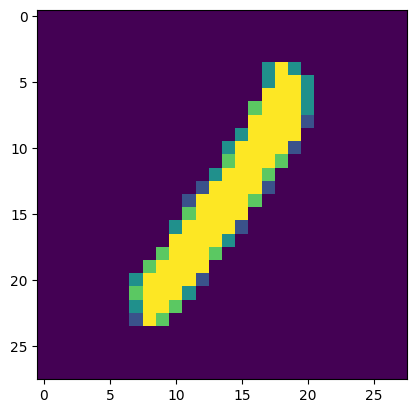

1


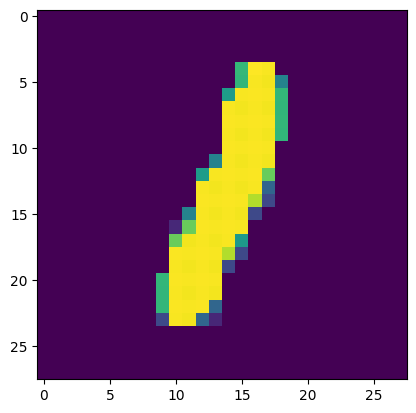

4


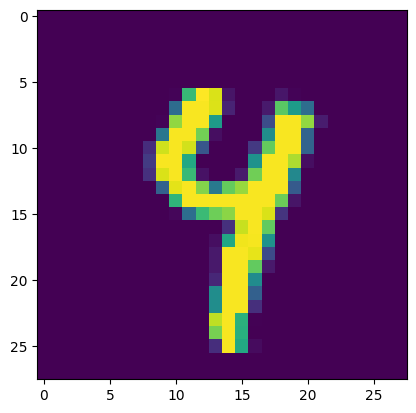

8


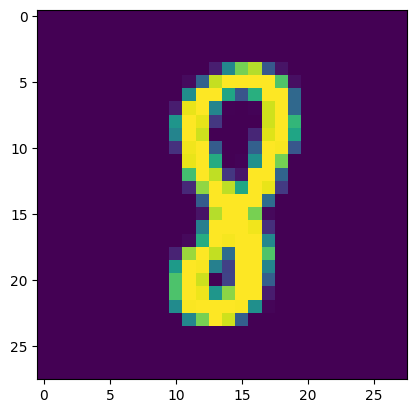

5


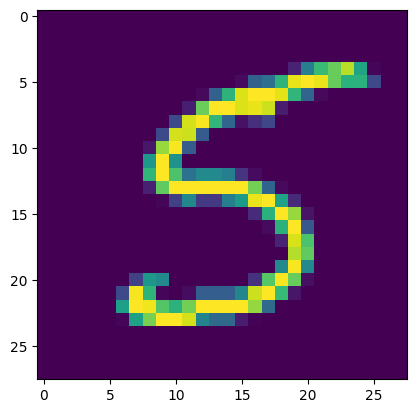

In [4]:
# Explore data
show5(trainloader)

In [10]:
def show_images(dataloader, num_images=25, row=5, col=5):
    images, labels = next(iter(dataloader))

    fig, axes = plt.subplots(row, col, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

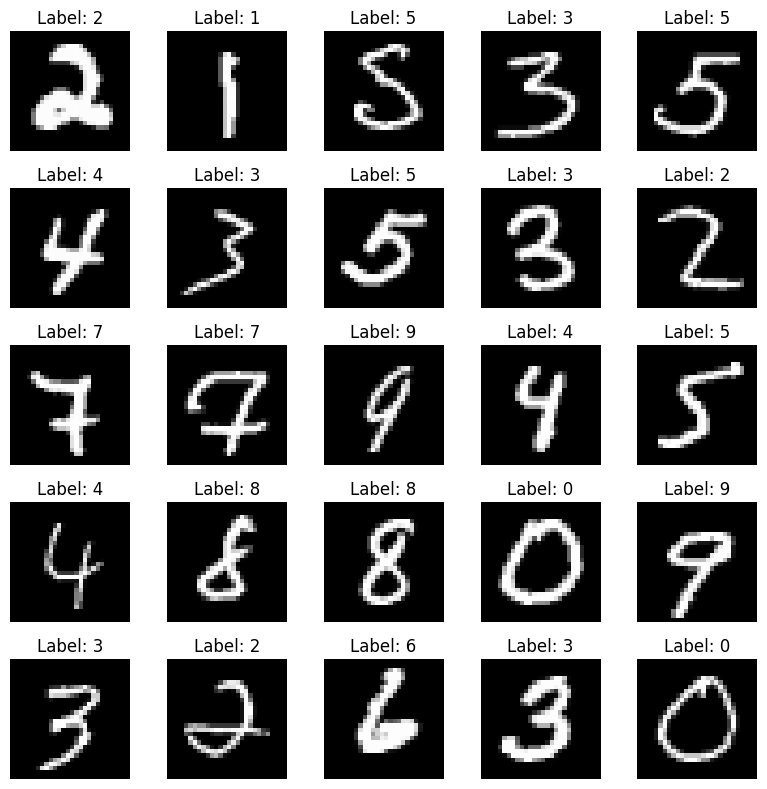

In [11]:
show_images(trainloader, num_images=25, row=5, col=5)

In [34]:
print(len(trainloader))
print(len(validloader))
print(len(testloader))

750
188
157


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [129]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def configure_optimizers_and_loss(self, optimizer_name='adam', loss_name='cross_entropy', learning_rate=0.001):
        optimizer_dict = {
            'adam': optim.Adam(self.parameters(), lr=learning_rate),
            'sgd': optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9),
            'rmsprop': optim.RMSprop(self.parameters(), lr=learning_rate)
        }

        loss_dict = {
            'cross_entropy': nn.CrossEntropyLoss(),
            'mse': nn.MSELoss(),
            'nll': nn.NLLLoss()
        }

        if optimizer_name.lower() not in optimizer_dict:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        if loss_name.lower() not in loss_dict:
            raise ValueError(f"Unsupported loss function: {loss_name}")

        self.optimizer = optimizer_dict[optimizer_name.lower()]
        self.criterion = loss_dict[loss_name.lower()]

        return self.optimizer, self.criterion

    def create_dataloaders(self, batch_size=64):
        train_dataset = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     download=True,
                                     transform=transform)
        train_size = int(0.8 * len(train_dataset))
        valid_size = len(train_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        return trainloader, validloader

    def train_model(self, trainloader, validloader, optimizer='adam', criterion='cross_entropy',
                    epochs=3, batch_size=64, patience=3, print_every=60, save_checkpoint=True,
                    save_loss=True, plot_loss=True):

        optimizer, criterion = self.configure_optimizers_and_loss(optimizer_name=optimizer, loss_name=criterion)
        steps = 0
        train_losses, valid_losses = [], []
        train_acc, valid_acc = [], []
        best_valid_loss = float('inf')
        epochs_no_improve = 0

        for e in range(epochs):
            train_loss = 0
            train_correct = 0
            train_total = 0
            self.train()
            for images, labels in trainloader:
                steps += 1
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                log_ps = self(images)
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Calculate training accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                train_correct += equals.sum().item()
                train_total += labels.size(0)

                if steps % print_every == 0:
                    valid_loss = 0
                    valid_correct = 0
                    valid_total = 0
                    self.eval()
                    with torch.no_grad():
                        for images, labels in validloader:
                            images, labels = images.to(device), labels.to(device)
                            log_ps = self(images)
                            loss = criterion(log_ps, labels)

                            valid_loss += loss.item()

                            ps = torch.exp(log_ps)
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels.view(*top_class.shape)
                            valid_correct += equals.sum().item()
                            valid_total += labels.size(0)

                    valid_losses.append(valid_loss / len(validloader))
                    train_losses.append(train_loss / steps)
                    train_acc.append(100 * train_correct / train_total)
                    valid_acc.append(100 * valid_correct / valid_total)

                    print(f"Epoch: {e+1}/{epochs}.. "
                          f"Train loss: {train_loss/steps:.3f}.. "
                          f"Train accuracy: {100*train_correct/train_total:.2f}%.. "
                          f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                          f"Valid accuracy: {100*valid_correct/valid_total:.2f}%")

                    # Early stopping and saving the best model
                    if valid_loss < best_valid_loss:
                        best_valid_loss = valid_loss
                        epochs_no_improve = 0
                        if save_checkpoint:
                            self.save_model()
                    else:
                        epochs_no_improve += 1
                        if epochs_no_improve >= patience:
                            print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
                            if save_loss:
                                self.save_loss_acc(train_losses, valid_losses, 'train_losses', 'valid_losses', 'losses.json')
                                self.save_loss_acc(train_acc, valid_acc, 'train_accuracies', 'valid_accuracies', 'accuracies.json')
                            return

        if save_loss:
            self.save_loss_acc(train_losses, valid_losses, 'train_losses', 'valid_losses', 'losses.json')
            self.save_loss_acc(train_acc, valid_acc, 'train_accuracies', 'valid_accuracies', 'accuracies.json')
        if plot_loss:
            self.plot_loss_vals(train_losses, valid_losses, 'Train Loss', 'Valid Loss')
            self.plot_loss_vals(train_acc, valid_acc, 'Train Accuracy', 'Valid Accuracy')

    def test_model(self, testloader, criterion='cross_entropy'):
        _, criterion = self.configure_optimizers_and_loss(loss_name=criterion)
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            self.eval()
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = self(images)
                loss = criterion(log_ps, labels)

                test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                correct += equals.sum().item()
                total += labels.size(0)

        print(f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {100*correct/total:.2f}%")

    def save_model(self):
        torch.save(self.state_dict(), 'best_model.pth')

    def save_loss_acc(self, train_vals, valid_vals, train_name, valid_name, fname):
        with open(fname, 'w') as f:
            json.dump({
                train_name: train_vals,
                valid_name: valid_vals}, f)

    def plot_loss_vals(self, train_vals, valid_vals, train_label, valid_label):
        plt.plot(train_vals, label=train_label)
        plt.plot(valid_vals, label=valid_label)
        plt.legend()
        plt.show()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.


- For the MNIST classification task, a common choice of loss function is CrossEntropyLoss, and a commonly used optimizer is Adam. Here is why I've specified and instantiated them along with the model:

  - Define the loss function: CrossEntropyLoss is suitable for multi-class classification tasks.
  - Choose the optimizer: Adam is a widely used optimizer that works well for many types of neural networks.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [132]:
# Ensure the device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# creating model object from the class
model = Net().to(device)

In [133]:
trainloader, validloader = model.create_dataloaders(batch_size=64)

In [134]:
print(len(trainloader))
print(len(validloader))

750
188


In [135]:
model.train_model(trainloader, validloader)

Epoch: 1/3.. Train loss: 1.887.. Train accuracy: 34.30%.. Valid loss: 0.869.. Valid accuracy: 83.00%
Epoch: 1/3.. Train loss: 1.147.. Train accuracy: 61.51%.. Valid loss: 0.268.. Valid accuracy: 92.12%
Epoch: 1/3.. Train loss: 0.841.. Train accuracy: 72.03%.. Valid loss: 0.199.. Valid accuracy: 94.16%
Epoch: 1/3.. Train loss: 0.677.. Train accuracy: 77.60%.. Valid loss: 0.167.. Valid accuracy: 95.55%
Epoch: 1/3.. Train loss: 0.574.. Train accuracy: 81.09%.. Valid loss: 0.135.. Valid accuracy: 96.18%
Epoch: 1/3.. Train loss: 0.498.. Train accuracy: 83.67%.. Valid loss: 0.117.. Valid accuracy: 96.50%
Epoch: 1/3.. Train loss: 0.446.. Train accuracy: 85.45%.. Valid loss: 0.112.. Valid accuracy: 96.58%
Epoch: 1/3.. Train loss: 0.404.. Train accuracy: 86.88%.. Valid loss: 0.120.. Valid accuracy: 96.35%
Epoch: 1/3.. Train loss: 0.369.. Train accuracy: 88.06%.. Valid loss: 0.102.. Valid accuracy: 96.88%
Epoch: 1/3.. Train loss: 0.343.. Train accuracy: 88.94%.. Valid loss: 0.100.. Valid accurac

Load the losses and accuracies in order to plot it

In [136]:
f = open('accuracies.json')
accuracies = json.load(f)

for key in accuracies:
    print(key)

train_accuracies
valid_accuracies


In [137]:
f = open('losses.json')
losses = json.load(f)

for key in losses:
    print(key)

train_losses
valid_losses


Plot the training loss (and validation loss/accuracy, if recorded).

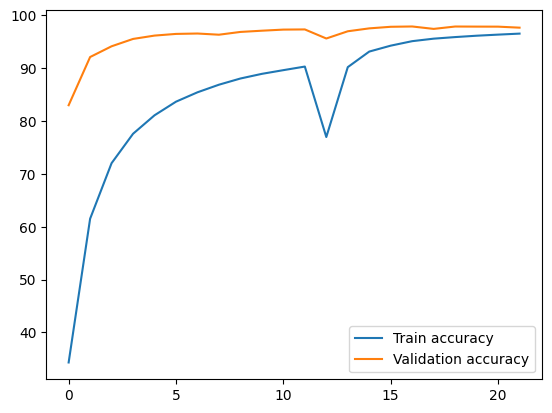

In [138]:
model.plot_loss_vals(accuracies['train_accuracies'], accuracies['valid_accuracies'], 'Train accuracy', 'Validation accuracy')

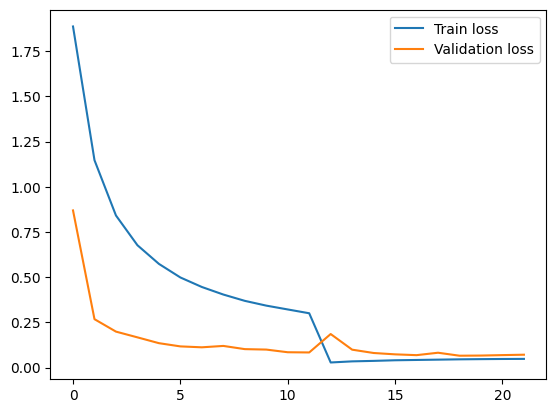

In [139]:
model.plot_loss_vals(losses['train_losses'], losses['valid_losses'], 'Train loss', 'Validation loss')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [143]:
import math
import matplotlib.pyplot as plt
import torch

def display_predictions(testloader, model, device, num_images=196, image_width=28, image_height=28):
    """
    Display a grid of images with predicted and actual labels from the testloader.

    Parameters:
    - testloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - model (torch.nn.Module): Trained model for making predictions.
    - device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
    - num_images (int): Number of images to display. Default is 196.
    - image_width (int): Width of the images. Default is 28.
    - image_height (int): Height of the images. Default is 28.
    """
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(testloader))  # Get a batch of images and labels
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        log_ps = model(images)
        ps = torch.exp(log_ps)
        _, predictions = ps.topk(1, dim=1)
        predictions = predictions.view(-1)

    # Determine grid size
    num_cells = math.ceil(math.sqrt(num_images))
    plt.figure(figsize=(15, 15))

    for plot_index in range(num_images):
        if plot_index >= len(images):  # Check if the index exceeds the batch size
            break
        predicted_label = predictions[plot_index].item()
        plt.subplot(num_cells, num_cells, plot_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        color_map = 'Greens' if predicted_label == labels[plot_index].item() else 'Reds'
        plt.imshow(images[plot_index].cpu().numpy().reshape((image_width, image_height)), cmap=color_map)
        plt.xlabel(predicted_label)

    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()

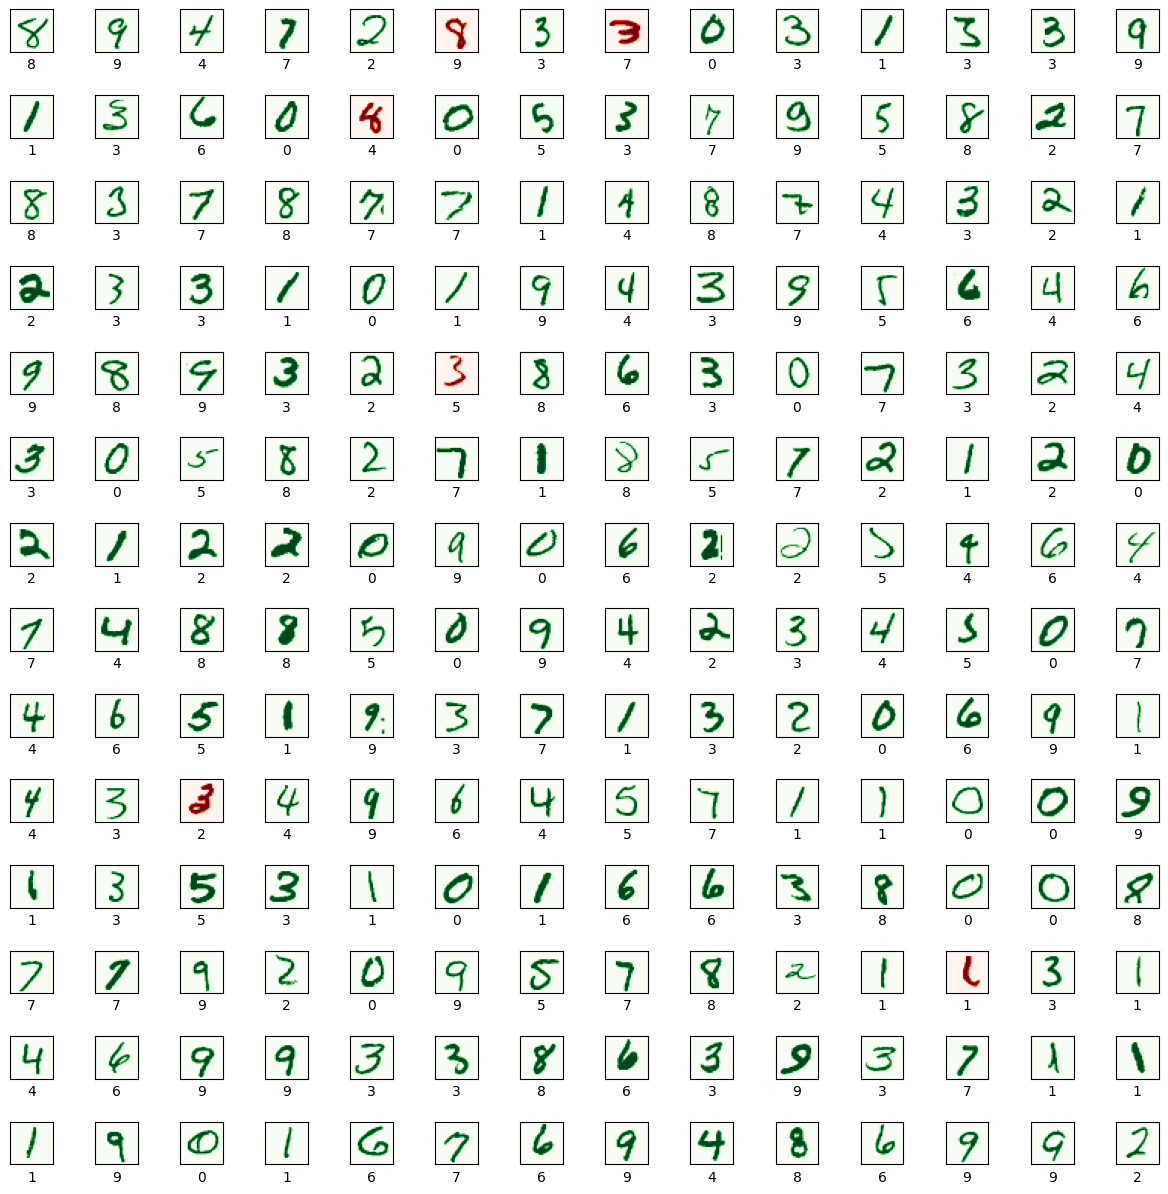

In [146]:
# Usage example:
display_predictions(testloader, model, device)

In [156]:
model.test_model(testloader)

Test loss: 0.061.. Test accuracy: 98.10%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [153]:
trainloader, validloader = model.create_dataloaders(batch_size=16)

In [154]:
print(len(trainloader))
print(len(validloader))

3000
750


In [157]:
model.train_model(trainloader, validloader, optimizer='sgd', criterion='nll',
                    epochs=5, batch_size=16)

Epoch: 1/5.. Train loss: 0.670.. Train accuracy: 79.27%.. Valid loss: 0.083.. Valid accuracy: 97.77%
Epoch: 1/5.. Train loss: 0.373.. Train accuracy: 88.65%.. Valid loss: 0.068.. Valid accuracy: 98.18%
Epoch: 1/5.. Train loss: 0.270.. Train accuracy: 91.84%.. Valid loss: 0.060.. Valid accuracy: 98.27%
Epoch: 1/5.. Train loss: 0.217.. Train accuracy: 93.36%.. Valid loss: 0.059.. Valid accuracy: 98.22%
Epoch: 1/5.. Train loss: 0.189.. Train accuracy: 94.19%.. Valid loss: 0.056.. Valid accuracy: 98.33%
Epoch: 1/5.. Train loss: 0.167.. Train accuracy: 94.91%.. Valid loss: 0.056.. Valid accuracy: 98.30%
Epoch: 1/5.. Train loss: 0.149.. Train accuracy: 95.39%.. Valid loss: 0.056.. Valid accuracy: 98.33%
Epoch: 1/5.. Train loss: 0.135.. Train accuracy: 95.81%.. Valid loss: 0.053.. Valid accuracy: 98.43%
Epoch: 1/5.. Train loss: 0.126.. Train accuracy: 96.08%.. Valid loss: 0.057.. Valid accuracy: 98.19%
Epoch: 1/5.. Train loss: 0.119.. Train accuracy: 96.35%.. Valid loss: 0.053.. Valid accurac

Load the losses and accuracies in order to plot it

In [158]:
f = open('accuracies.json')
accuracies = json.load(f)

for key in accuracies:
    print(key)

train_accuracies
valid_accuracies


In [159]:
f = open('losses.json')
losses = json.load(f)

for key in losses:
    print(key)

train_losses
valid_losses


Plot the training loss (and validation loss/accuracy, if recorded).

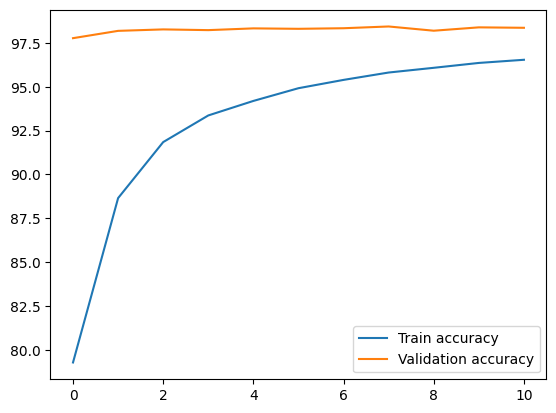

In [160]:
model.plot_loss_vals(accuracies['train_accuracies'], accuracies['valid_accuracies'], 'Train accuracy', 'Validation accuracy')

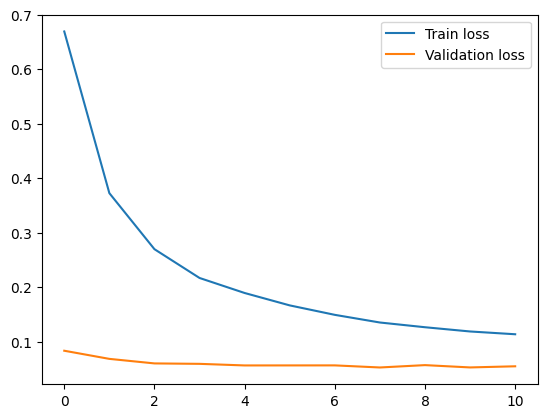

In [161]:
model.plot_loss_vals(losses['train_losses'], losses['valid_losses'], 'Train loss', 'Validation loss')

Test the model

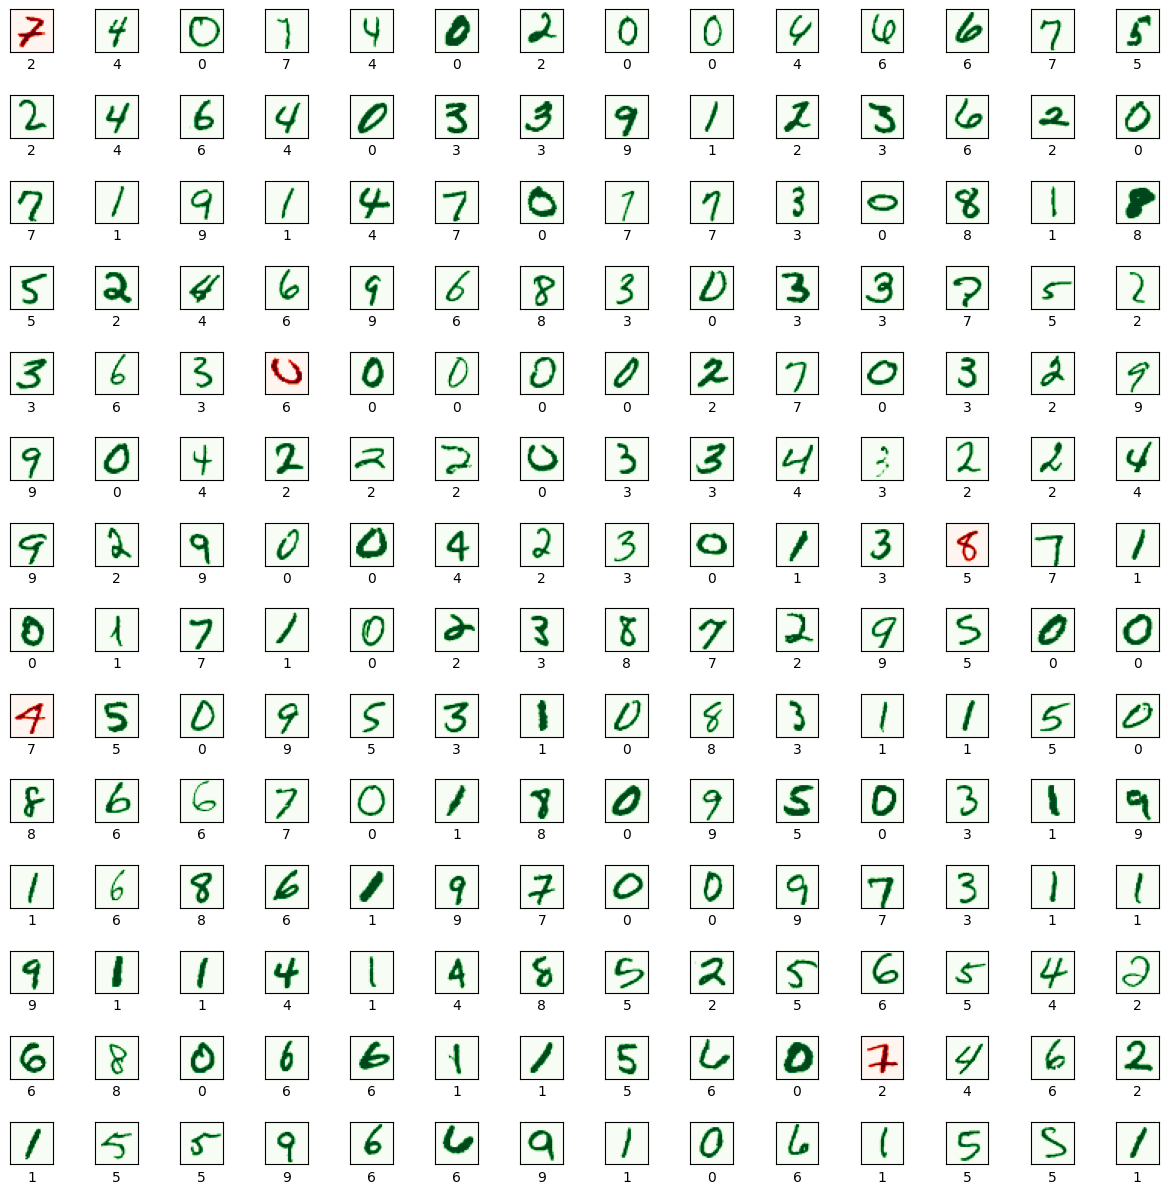

In [162]:
# Usage example:
display_predictions(testloader, model, device)

In [163]:
model.test_model(testloader)

Test loss: 0.051.. Test accuracy: 98.37%


## Saving your model
Using `torch.save`, save your model for future loading.